In [28]:

import random

city_dist_mat = None

# config
gene_len = 11
individual_num = 60
gen_num = 400
mutate_prob = 0.25


def copy_list(old_arr: [int]):
    new_arr = []
    for element in old_arr:
        new_arr.append(element)
    return new_arr


# Individual class
class Individual:
    def __init__(self, genes=None):
        # random genes
        if genes is None:
            genes = [i for i in range(gene_len)]
            random.shuffle(genes)
        self.genes = genes
        self.fitness = self.evaluate_fitness()

    def evaluate_fitness(self):
        # calculate fitness
        fitness = 0.0
        for i in range(gene_len - 1):
            # orgin and destination
            from_idx = self.genes[i]
            to_idx = self.genes[i + 1]
            fitness += city_dist_mat[from_idx, to_idx]
        # connect first and last address
        fitness += city_dist_mat[self.genes[-1], self.genes[0]]
        return fitness


class Ga:
    def __init__(self, input_):
        global city_dist_mat
        city_dist_mat = input_
        self.best = None  # best individual in each generation
        self.individual_list = []  # individuals in each generation
        self.result_list = []  # result of each generation
        self.fitness_list = []  # fitness of each generation

    def cross(self):
        new_gen = []
        random.shuffle(self.individual_list)
        for i in range(0, individual_num - 1, 2):
            # parent genes
            genes1 = copy_list(self.individual_list[i].genes)
            genes2 = copy_list(self.individual_list[i + 1].genes)
            index1 = random.randint(0, gene_len - 2)
            index2 = random.randint(index1, gene_len - 1)
            pos1_recorder = {value: idx for idx, value in enumerate(genes1)}
            pos2_recorder = {value: idx for idx, value in enumerate(genes2)}
            # cross
            for j in range(index1, index2):
                value1, value2 = genes1[j], genes2[j]
                pos1, pos2 = pos1_recorder[value2], pos2_recorder[value1]
                genes1[j], genes1[pos1] = genes1[pos1], genes1[j]
                genes2[j], genes2[pos2] = genes2[pos2], genes2[j]
                pos1_recorder[value1], pos1_recorder[value2] = pos1, j
                pos2_recorder[value1], pos2_recorder[value2] = j, pos2
            new_gen.append(Individual(genes1))
            new_gen.append(Individual(genes2))
        return new_gen

    def mutate(self, new_gen):
        for individual in new_gen:
            if random.random() < mutate_prob:
                # flip subsequence
                old_genes = copy_list(individual.genes)
                index1 = random.randint(0, gene_len - 2)
                index2 = random.randint(index1, gene_len - 1)
                genes_mutate = old_genes[index1:index2]
                genes_mutate.reverse()
                individual.genes = old_genes[:index1] + genes_mutate + old_genes[index2:]
        # merge new generation and old generation
        self.individual_list += new_gen

    def select(self):
        # Championship
        group_num = 10  # Group number
        group_size = 10  # Group size
        group_winner = individual_num // group_num  # Winners in each group
        winners = []  # Final winners
        for i in range(group_num):
            group = []
            for j in range(group_size):
                # Randomly select a player
                player = random.choice(self.individual_list)
                player = Individual(player.genes)
                group.append(player)
            group = Ga.rank(group)
            # Choose winners
            winners += group[:group_winner]
        self.individual_list = winners

    @staticmethod
    def rank(group):
        # bubble sort
        for i in range(1, len(group)):
            for j in range(0, len(group) - i):
                if group[j].fitness > group[j + 1].fitness:
                    group[j], group[j + 1] = group[j + 1], group[j]
        return group

    def next_gen(self):
        # Cross
        new_gen = self.cross()
        # Mutate
        self.mutate(new_gen)
        # Select
        self.select()
        # Find best individual in this generation
        for individual in self.individual_list:
            if individual.fitness < self.best.fitness:
                self.best = individual

    def train(self):
        # First generation
        self.individual_list = [Individual() for _ in range(individual_num)]
        self.best = self.individual_list[0]
        # Iteration
        for i in range(gen_num):
            self.next_gen()
            # Connect first and last address
            result = copy_list(self.best.genes)
            result.append(result[0])
            self.result_list.append(result)
            self.fitness_list.append(self.best.fitness)
        return self.result_list, self.fitness_list

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/xs/hclrjpwn1k16cw_5_3slwgx00000gn/T/ipykernel_22320/2898661639.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


shortest path length:  0.0007155068920005455
shortest path:  [10, 6, 1, 5, 2, 7, 3, 4, 9, 8, 0, 10]


/var/folders/xs/hclrjpwn1k16cw_5_3slwgx00000gn/T/ipykernel_22320/2898661639.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


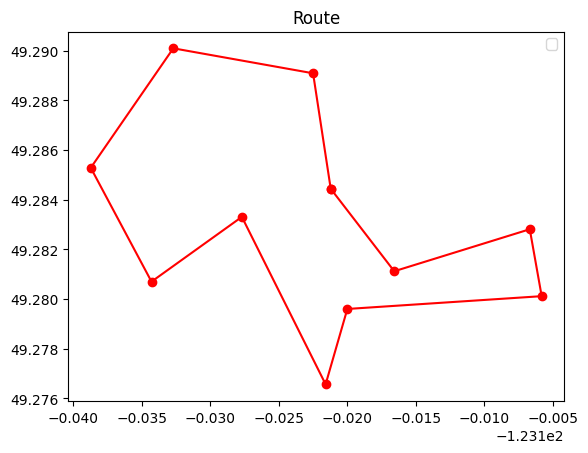

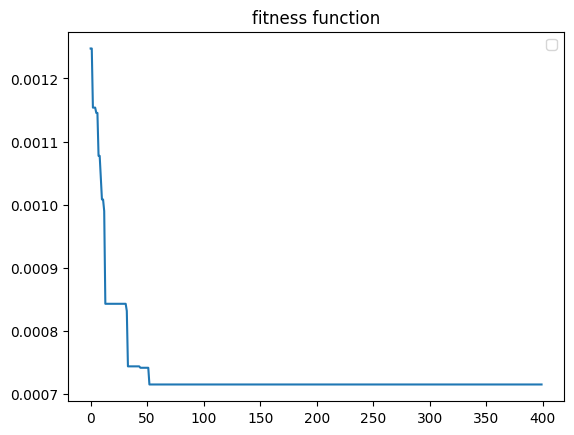

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import folium




attractions = []


with open('sites.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    # Skip the header row
    next(reader)  
    for row in reader:
        latitude = float(row[1])
        longitude = float(row[2])
        attractions.append([longitude, latitude])

attractions_array = np.array(attractions)


def build_dist_mat(input_list):
    n = gene_len
    dist_mat = np.zeros([n, n])
    for i in range(n):
        for j in range(i + 1, n):
            d = input_list[i, :] - input_list[j, :]
            # calculate Euclidean distance
            dist_mat[i, j] = np.dot(d, d)
            dist_mat[j, i] = dist_mat[i, j]
    return dist_mat


# city position list
city_pos_list = attractions_array  
# city distance matrix
city_dist_mat = build_dist_mat(attractions_array)

# genetic algorithm operation
ga = Ga(city_dist_mat)
result_list, fitness_list = ga.train()
result = result_list[-1]
result_pos_list = city_pos_list[result, :]

fig = plt.figure()
plt.plot(result_pos_list[:, 0], result_pos_list[:, 1], 'o-r')
plt.title(u"Route")
plt.legend()
fig.show()

fig = plt.figure()
plt.plot(fitness_list)
plt.title(u"fitness function")
plt.legend()
fig.show()

print("shortest path length: ", fitness_list[-1])  
print("shortest path: ", result)

result_pos_list[:, [0, 1]] = result_pos_list[:, [1, 0]]

m = folium.Map(location=(49.284, -123.125), zoom_start=14, tiles="cartodb positron")
for i in range(1,len(result_pos_list)):
    folium.Marker(
        location=result_pos_list[i],
        tooltip= result[i],
        icon=folium.Icon(icon="cloud",color="orange"),
    ).add_to(m)
folium.PolyLine(result_pos_list, tooltip="Route").add_to(m)
m
